# Eaxmple training CAE on FashionMNIST with multiple GPUs

## Uses Pytorch's DataParallel module.

See https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html for more details.

Apparently some of the internal methods of the model may not be accessible after wrapping with DataParallel.  https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html.  This may be a problem when trying to create latent vectors and generating samples later.  May need to subclass nn.DataParallel in a parallel-specific autoencoder class.  Then would need to make sure that any model created and saved would be portable to a single-gpu or cpu setup.

Note: Using DistributedDataParallel does not work on Windows or OSX since Pytorch doesn't support distributed training on these platforms.  DistributedDataParallel uses multiprocessing and potentially could be faster than DataParallel. See https://pytorch.org/tutorials/intermediate/ddp_tutorial.html. Could try using a Docker container to do this.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from time import time
import os

import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from Autoencoders.encoders import Encoder2DConv
from Autoencoders.decoders import Decoder2DConv
from Autoencoders.autoencoders import Autoencoder
from Autoencoders.losses import vae_loss

from sklearn.manifold import TSNE

In [2]:
torch.distributed.is_available()

False

## Load FashionMNIST data and create a dataloader

In [3]:
batch_size = 128

traindata = datasets.FashionMNIST('./sampledata/FashionMNIST', download=True, train=True, transform=transforms.ToTensor())
trainloader = DataLoader(traindata, batch_size=batch_size, num_workers=8)

testdata = datasets.FashionMNIST('./sampledata/FashionMNIST', download=True, train=False, transform=transforms.ToTensor())
testloader = DataLoader(testdata, batch_size=batch_size, num_workers=8)

In [4]:
for data, _ in trainloader:
    print(data.size())
    break

torch.Size([128, 1, 28, 28])


## Parameters

In [5]:
inputdims = (28,28)
latentdims = 32
nlayers = 2

use_cuda = True

epochs = 20

## Create the single-GPU Convolutional Autoencoder (CAE)


In [6]:
cae_encoder = Encoder2DConv(inputdims, latentdims, nlayers=nlayers, use_batchnorm=True)
cae_decoder = Decoder2DConv(inputdims, latentdims, nlayers=nlayers, use_batchnorm=True)
cae = Autoencoder(cae_encoder, cae_decoder)
if use_cuda == True:
    cae = cae.cuda()
cae_loss = torch.nn.functional.mse_loss
cae_optimizer = torch.optim.Adam(cae.parameters())


## Train the single-GPU CAE

Train Epoch: 0 [58880/60000 (98%)]	Loss: 8.4713970
====> Epoch: 0 Average loss: 16.1311
Train Epoch: 1 [58880/60000 (98%)]	Loss: 7.322164
====> Epoch: 1 Average loss: 7.9046
Train Epoch: 2 [58880/60000 (98%)]	Loss: 6.761413
====> Epoch: 2 Average loss: 7.0991
Train Epoch: 3 [58880/60000 (98%)]	Loss: 6.379301
====> Epoch: 3 Average loss: 6.6472
Train Epoch: 4 [58880/60000 (98%)]	Loss: 6.131902
====> Epoch: 4 Average loss: 6.3568
Train Epoch: 5 [58880/60000 (98%)]	Loss: 5.954562
====> Epoch: 5 Average loss: 6.1449
Train Epoch: 6 [58880/60000 (98%)]	Loss: 5.796043
====> Epoch: 6 Average loss: 5.9640
Train Epoch: 7 [58880/60000 (98%)]	Loss: 5.683897
====> Epoch: 7 Average loss: 5.8095
Train Epoch: 8 [58880/60000 (98%)]	Loss: 5.562890
====> Epoch: 8 Average loss: 5.6843
Train Epoch: 9 [58880/60000 (98%)]	Loss: 5.432785
====> Epoch: 9 Average loss: 5.5799
Train Epoch: 10 [58880/60000 (98%)]	Loss: 5.351877
====> Epoch: 10 Average loss: 5.5252
Train Epoch: 11 [58880/60000 (98%)]	Loss: 5.291460

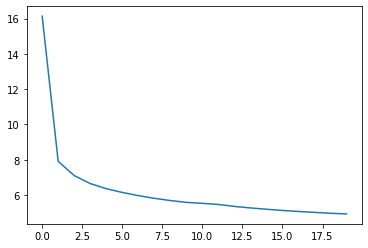

In [7]:
def train_cae(epochs):
    cae.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(trainloader):
        if use_cuda: 
            x = x.cuda()
        cae_optimizer.zero_grad()
        recon_x = cae(x)
        loss = cae_loss(recon_x, x, reduction='sum')
        loss.backward()
        train_loss += loss.item()
        cae_optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.item() / len(x)),
                end="\r", flush=True)

    print('\n====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))
    
    return train_loss / len(trainloader.dataset)

cae_epoch_loss = []

t0 = time()
for epoch in range(epochs):
    loss = train_cae(epoch)
    cae_epoch_loss.append(loss)

print('Total training time: {:.2f} seconds'.format(time()-t0))
plt.plot(cae_epoch_loss)

## Create the multi-GPU CAE

In [12]:
device = torch.device("cuda:0")  

mgpu_encoder = Encoder2DConv(inputdims, latentdims, nlayers=nlayers, use_batchnorm=True)
mgpu_decoder = Decoder2DConv(inputdims, latentdims, nlayers=nlayers, use_batchnorm=True)
model = Autoencoder(mgpu_encoder, mgpu_decoder)
# output_device defaults to device_ids[0]
mgpu_model = torch.nn.DataParallel(model)
mgpu_model.to(device)

mgpu_loss = torch.nn.functional.mse_loss
mgpu_optimizer = torch.optim.Adam(mgpu_model.parameters())

def train_mgpu_model(epochs):
    mgpu_model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(trainloader):
        mgpu_optimizer.zero_grad()
        x = x.to(device)
        recon_x = mgpu_model(x)
        loss = mgpu_loss(recon_x, x, reduction='sum')
        loss.backward()
        train_loss += loss.item()
        mgpu_optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(trainloader.dataset),
                100. * batch_idx / len(trainloader),
                loss.item() / len(x)),
                end="\r", flush=True)

    print(x.size())
    print('\n====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))
    
    return train_loss / len(trainloader.dataset)


    

## Train the multi-gpu setup

In [13]:
mgpu_epoch_loss = []

t0 = time()
for epoch in range(epochs):
    loss = train_mgpu_model(epoch)
    mgpu_epoch_loss.append(loss)

print('Total training time: {:.2f} seconds'.format(time()-t0))
plt.plot(mgpu_epoch_loss)

torch.Size([96, 1, 28, 28]) (98%)]	Loss: 8.7417435

====> Epoch: 0 Average loss: 16.3835
torch.Size([96, 1, 28, 28]) (98%)]	Loss: 7.445154

====> Epoch: 1 Average loss: 7.9721
torch.Size([96, 1, 28, 28]) (98%)]	Loss: 6.852514

====> Epoch: 2 Average loss: 7.1412


KeyboardInterrupt: 

## Uh-oh, DataParallel takes longer (193s vs 140s).  Gotta figure that out.  For now, I'll use single GPU training.